# Examining Trends in Delta Airlines Stocks 2013 - 2017

## Assignment 2: Data Parsing & Time Series

### Lucy Byrne - 15363761

This notebook uses Stock Data from Delta Airlines to analyse the following:

- What is the general trend of DAL stocks:
    - Over 5 years
    - During each year
- What is the average price for each date?
- What causes sudden low spikes?
- How often do days close higher than they opened?
- Do days or months influence if a date will close higher than it opened?

## Task 1) Data collection: Choose one of the stocks to analyse.
Chosen Dataset: http://mlg.ucd.ie/modules/COMP30760/stocks/dal.html

## Use Python to download the HTML page for your chosen stock:

In [2]:
import urllib.request #parsing the webpage

url = "http://mlg.ucd.ie/modules/COMP30760/stocks/dal.html" #Delta Airlines Data
response = urllib.request.urlopen(url)
text = response.read().decode()

## Task 2) Data parsing: Using Python, automatically parse and extract the relevant stock price data from the stock’s HTML page.

In the cell below:

- I use BeautifulSoup to interate through the table and select each row. 
- I store this in a list
- Then I write this list into a csv file, and perform the necessary text editing to add commas in the correct areas
- I assembled all of the seperate years into one big table, so removed each header given in the html page

In [3]:
import bs4 #beautifulsoup for sorting through tags in HTML
import csv #for creating a csv file to hold the tables

table = [] #Empty list to store all of the values on this webpage

parser = bs4.BeautifulSoup(text,"html.parser")

for match in parser.find_all("tr"): # Find every table row (tr) in the webpage
    for line in match:
        text = line.get_text() #get the text inside of the tr tag
        table.append(text) # add this text to the list

size = int(len(table)/7) - 1 # There are 7 columns in this dataset. This calculation takes the total number of entries and 
                             # divides it by 7 to get the total number of rows. The -1 accounts for the header row that's pre-written

f = open("stocks.csv","w+") #creating a csv file to store all of these rows

f.write("Day,Month,Year,Open,High,Low,Close"+"\n") #write the header
table = table[7:] # remove the first 7 entries in the list as we have written them already

for i in range(size): # for every row in the table
    row = "" 

    # get the first 7 entries, put a comma between each one
    for n in range(7): 
        row = row + table[n]+","
    
    table = table[7:] # remove the 7 entries
    end = len(row) # get length of the row is so that we can remove the final comma
    row2 = row[:end-1] # remove final comma
    
    if(row2 != "Day,Month,Year,Open,High,Low,Close"): #this line is repeated in the webpage so we remove it to make one big table
        f.write(row2+"\n") #write the newly created comma-seperated row and add a newline
    
f.close()

## This dataset should be represented as a time series in a Pandas Data Frame.

In the cell below: 

- Read the csv into a dataframe
- Iterate through the rows and combine the year, month, and day into a single date
- Convert this to python datetime format
- Append this list of dates as a new column in the dataframe

Throughout this notebook, I will use both the single date format column and the seperate columns of day, month, and year.


In [136]:
import pandas as pd
import datetime as dt

df = pd.read_csv("stocks.csv")

dateList = [] #empty list to hold the dates

for index, row in df.iterrows(): 
    # convert each value to an int, then convert each int to a string 
    year = str(int(row['Year']))
    month = str(int(row['Month']))
    day = str(int(row['Day']))
    
    dateString = year + "-" + month  + "-" + day #create a string combining year-month-day
    dateTime = dt.datetime.strptime(dateString,"%Y-%m-%d").date() #convert to datetime format
    dateList.append(dateTime) #add to list

df['date'] = pd.Series(dateList, index=df.index) # add new column of dates to the dataframe

stocks = df.filter(['date', 'Open', 'High', 'Low', 'Close']) #take just the date and stock info and create new dataframe

The dataframe now looks like this:

In [137]:
stocks.head()

,date,Open,High,Low,Close
0,2013-01-02,12.07,12.28,11.97,12.23
1,2013-01-03,12.14,12.61,12.12,12.58
2,2013-01-04,12.56,13.08,12.55,12.98
3,2013-01-07,13.14,13.38,12.89,12.99
4,2013-01-08,13.05,13.26,12.87,12.98


However, I will need to use separate columns of "day, month, year" to make groups for analysis.

Below, I use the datetime column I created to extract the relevant info and make new columns in the dataframe.

In [138]:
date = stocks.loc[0:, "date"]

months = []
years = []
days = []

for i in range(len(date)):
    months.append(date[i].strftime('%m'))
    years.append(date[i].strftime('%Y'))
    days.append(date[i].strftime('%d'))
    
stocks['month'] = pd.Series(months, index=stocks.index)
stocks['day'] = pd.Series(days, index=stocks.index)
stocks['year'] = pd.Series(years, index=stocks.index)

Below is the base dataframe which I will use for analysis throughout the notebook

In [139]:
stocks.head()

,date,Open,High,Low,Close,month,day,year
0,2013-01-02,12.07,12.28,11.97,12.23,01,02,2013
1,2013-01-03,12.14,12.61,12.12,12.58,01,03,2013
2,2013-01-04,12.56,13.08,12.55,12.98,01,04,2013
3,2013-01-07,13.14,13.38,12.89,12.99,01,07,2013
4,2013-01-08,13.05,13.26,12.87,12.98,01,08,2013


## Task 3) Analysis and interpretation: Analyse and visualise the time series data, at daily, monthly, and annual frequencies. Use plots and tables where appropriate. Discuss the trends in the time series.


### Overview of Data

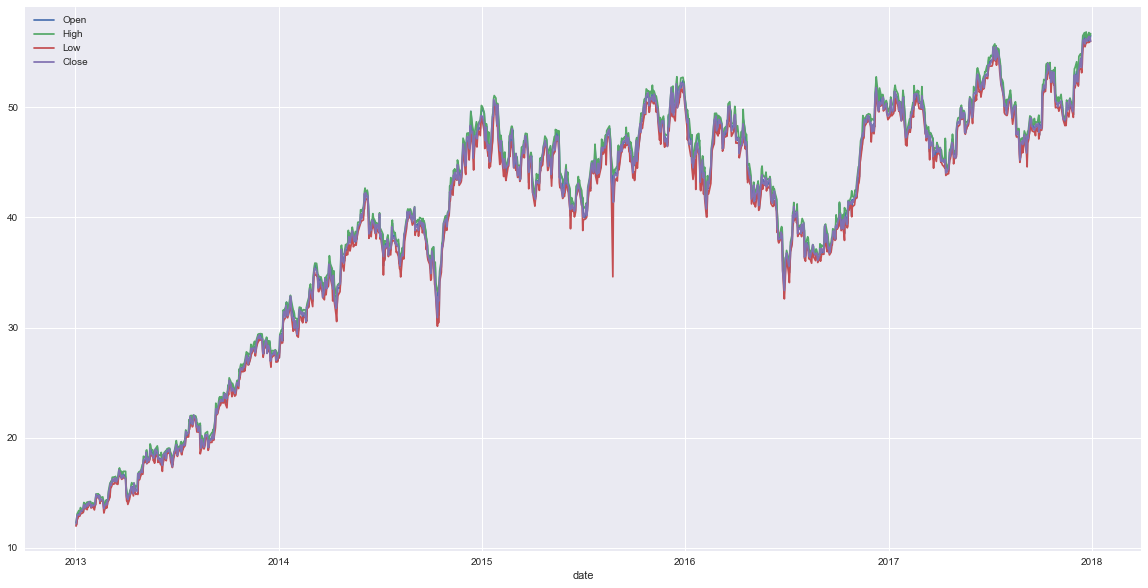

In [140]:
stocks = stocks.set_index('date')
stocks.plot(figsize=(20, 10))

It's difficult to see each individual line, so below I split them into seperate graphs.

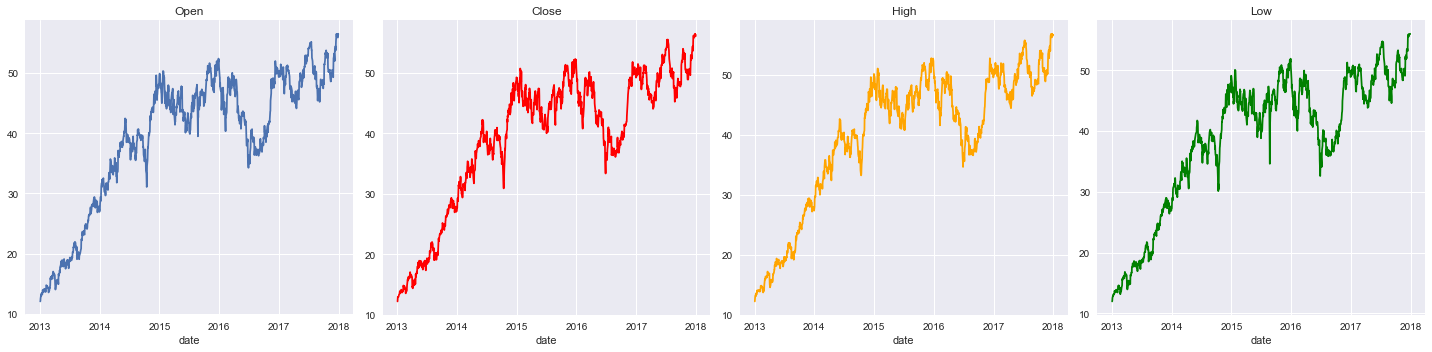

In [141]:
import matplotlib
import matplotlib.pyplot as plt

#stocks = stocks.set_index('date')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4)

stocks['Open'].plot(x='date', y='Open', legend=False, ax=ax1, figsize=(20, 5))
ax1.set_title("Open")

stocks['Close'].plot(x='date', y='Close', legend=False, ax=ax2, figsize=(20, 5), color='red')
ax2.set_title("Close")

stocks['High'].plot(x='date', y='High', legend=False, ax=ax3, figsize=(20, 5), color='orange')
ax3.set_title("High")

stocks['Low'].plot(x='date', y='Low', legend=False, ax=ax4, figsize=(20, 5), color='green')
ax4.set_title("Low")

plt.tight_layout()

### Getting an average

Below I use the high and low values to get an average for the day, and add it as a column to my dataframe

In [142]:
stocks = stocks.reset_index()

average = []

for i in range(len(stocks)):
    h = stocks.loc[i, "High"]
    l = stocks.loc[i, "Low"]
    
    av = (h+l)/2
        
    average.append(av)

stocks['avg'] = pd.Series(average, index=stocks.index)

stocks.head()

,date,Open,High,Low,Close,month,day,year,avg
0,2013-01-02,12.07,12.28,11.97,12.23,01,02,2013,12.125
1,2013-01-03,12.14,12.61,12.12,12.58,01,03,2013,12.365
2,2013-01-04,12.56,13.08,12.55,12.98,01,04,2013,12.815
3,2013-01-07,13.14,13.38,12.89,12.99,01,07,2013,13.135
4,2013-01-08,13.05,13.26,12.87,12.98,01,08,2013,13.065


### Average Stocks 2013 - 2017

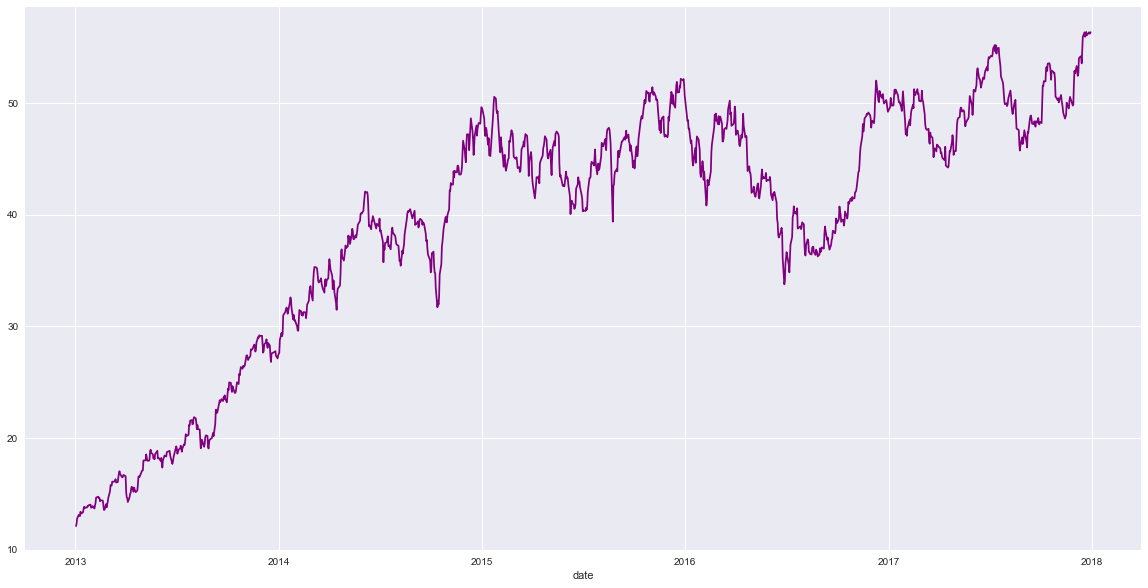

In [143]:
stocks.plot(x='date', y='avg', legend=False, figsize=(20, 10), color='purple')

## Yearly Overview

All graphs adjusted to the same scale

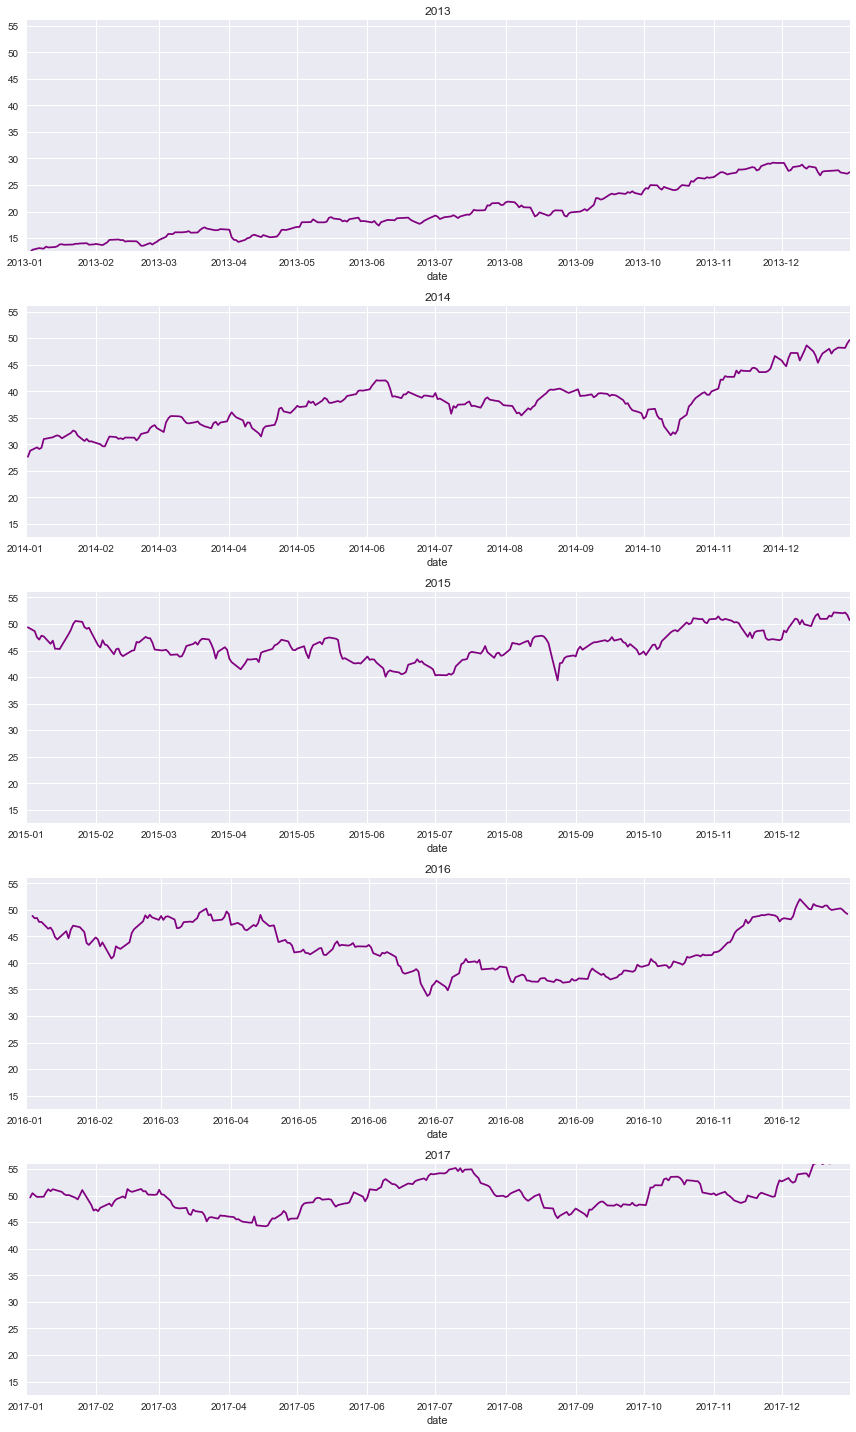

In [144]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1)

stocks[stocks['year'] == '2013'].plot(x='date', y='avg', legend=False, ax=ax1, figsize=(12, 20), color='purple') #purple scheme kept to show it's still using the 'avg' column
ax1.set_title("2013")
ax1.set_ylim([12.5,56]) #adjusting to same scale
ax1.set_xlim(['2013-01-01','2013-12-31']) #2014 label was showing at the end, this removes it

stocks[stocks['year'] == '2014'].plot(x='date', y='avg', legend=False, ax=ax2, figsize=(12, 20), color='purple')
ax2.set_title("2014")
ax2.set_ylim([12.5,56])
ax2.set_xlim(['2014-01-01','2014-12-31'])

stocks[stocks['year'] == '2015'].plot(x='date', y='avg', legend=False, ax=ax3, figsize=(12, 20), color='purple')
ax3.set_title("2015")
ax3.set_ylim([12.5,56])
ax3.set_xlim(['2015-01-01','2015-12-31'])

stocks[stocks['year'] == '2016'].plot(x='date', y='avg', legend=False, ax=ax4, figsize=(12, 20), color='purple')
ax4.set_title("2016")
ax4.set_ylim([12.5,56])
ax4.set_xlim(['2016-01-01','2016-12-31'])

stocks[stocks['year'] == '2017'].plot(x='date', y='avg', legend=False, ax=ax5, figsize=(12, 20), color='purple')
ax5.set_title("2017")
ax5.set_ylim([12.5,56])
ax5.set_xlim(['2017-01-01','2017-12-31'])

plt.tight_layout()

# What caused the sudden drop in August 2015?

We can see from the graph below that stocks drop to an abnormally low point for one day

(735599.0, 735963.0)

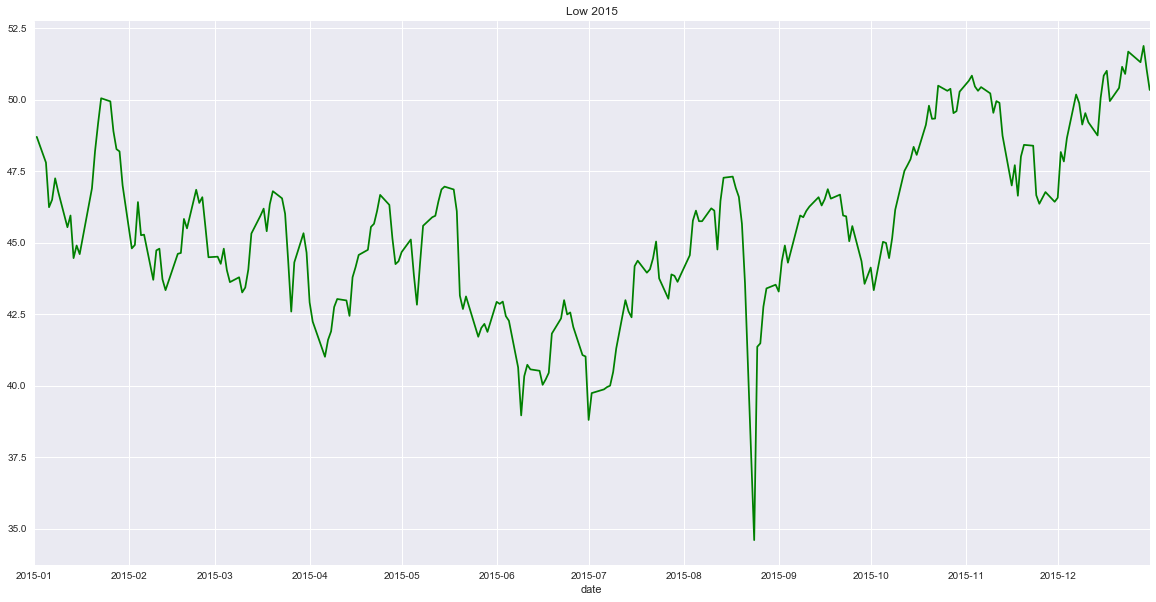

In [145]:
plt = stocks[stocks['year'] == '2015'].plot(x='date', y='Low', legend=False, figsize=(20, 10), color='green')
plt.set_title("Low 2015")
plt.set_xlim(['2015-01-01','2015-12-31'])

We can zoom in to find the exact date.

(735825.0, 735841.0)

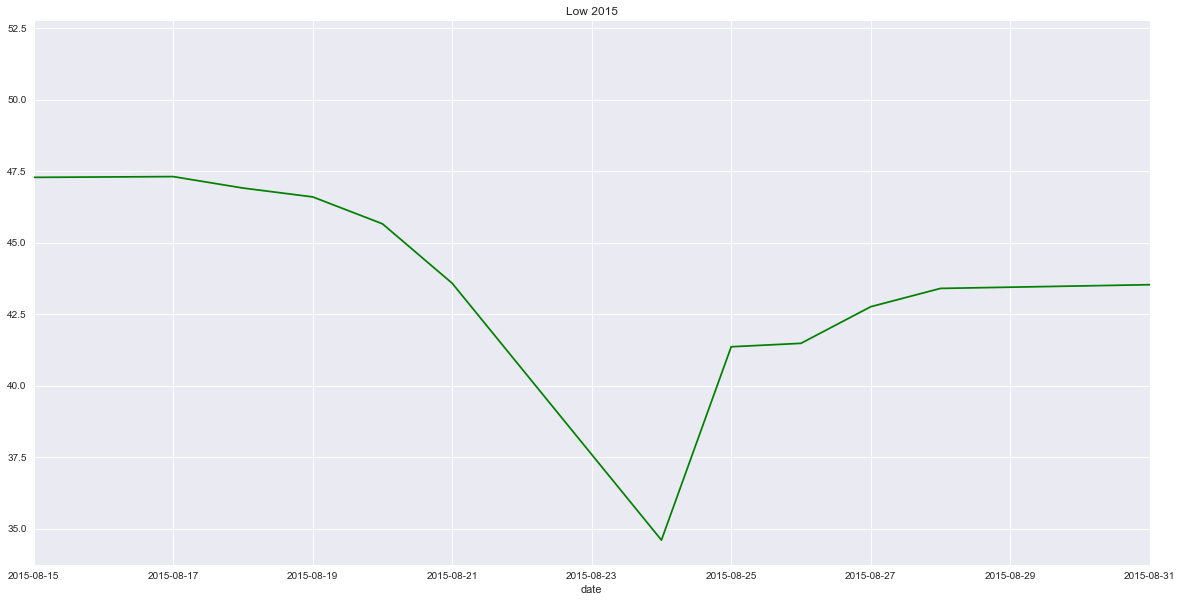

In [146]:
plt = stocks[stocks['year'] == '2015'].plot(x='date', y='Low', legend=False, figsize=(20, 10), color='green')
plt.set_title("Low 2015")
plt.set_xlim(['2015-08-15','2015-08-31'])

Googling that date shows that Delta Airlines suffered a computer outage on August 24th 2015 that made them [lose 100 million dollars in revenue.](https://www.usatoday.com/story/travel/flights/todayinthesky/2016/09/06/delta-computer-outage/89903948/)

# How often did the day close higher than it opened?

### Percentage of days that year where 'Close' was higher than 'Open'

To calculate this, I added a column that signifies True if it it closed higher, and False if it did not

In [147]:
closedHigh = []
string = ""

for i in range(len(stocks)):
    o = stocks.loc[i, "Open"]
    c = stocks.loc[i, "Close"]
    if o < c:
        string = True
    elif o >= c:
        string = False
        
    closedHigh.append(string)

stocks['closedHigher'] = pd.Series(closedHigh, index=stocks.index)

stocks.head()

,date,Open,High,Low,Close,month,day,year,avg,closedHigher
0,2013-01-02,12.07,12.28,11.97,12.23,01,02,2013,12.125,True
1,2013-01-03,12.14,12.61,12.12,12.58,01,03,2013,12.365,True
2,2013-01-04,12.56,13.08,12.55,12.98,01,04,2013,12.815,True
3,2013-01-07,13.14,13.38,12.89,12.99,01,07,2013,13.135,False
4,2013-01-08,13.05,13.26,12.87,12.98,01,08,2013,13.065,False


We can see from the bar chart below that every year around 50% of days closed higher than it opened. 2015 was the lowest year for this. 

Text(0,0.5,'% Days that closed higher')

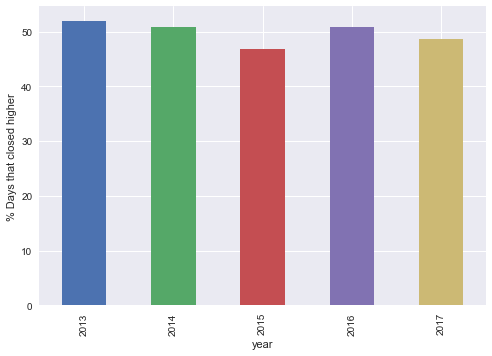

In [148]:
num_high_by_year = stocks.groupby('year')['closedHigher'].sum()
pct_high_by_year = 100*num_high_by_year/stocks.groupby('year')['date'].count()
plt = pct_high_by_year.plot(kind='bar')
plt.set_ylabel('% Days that closed higher')

# Do days or months influence if a date will close higher than it opened?

### Days

First, I use datetime to find the weekday for each date, then add this column to the dataframe

In [149]:
days = []

for i in range(len(stocks)):
    week = stocks.loc[i, "date"]  
    weekD = week.strftime("%A")
    days.append(weekD)

stocks['weekday'] = pd.Series(days, index=stocks.index)

stocks.head()

,date,Open,High,Low,Close,month,day,year,avg,closedHigher,weekday
0,2013-01-02,12.07,12.28,11.97,12.23,01,02,2013,12.125,True,Wednesday
1,2013-01-03,12.14,12.61,12.12,12.58,01,03,2013,12.365,True,Thursday
2,2013-01-04,12.56,13.08,12.55,12.98,01,04,2013,12.815,True,Friday
3,2013-01-07,13.14,13.38,12.89,12.99,01,07,2013,13.135,False,Monday
4,2013-01-08,13.05,13.26,12.87,12.98,01,08,2013,13.065,False,Tuesday


Then, select only the rows where closedHigher is true.

We can see from the pie chart below that the distribution of days is quite equal, showing that it is not a factor in if a day does well or not

Text(0,0.5,'')

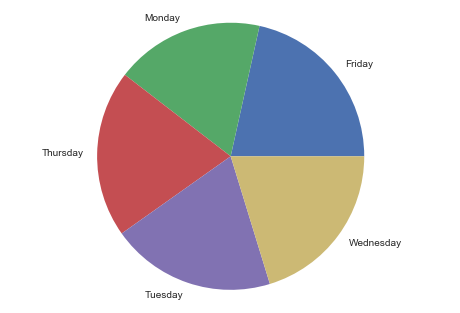

In [150]:
trueHigher = stocks.loc[stocks['closedHigher'] == True]

num_higher = trueHigher.groupby('weekday')['closedHigher'].sum()
plt = num_higher.plot(kind='pie')
plt.axis('equal')
plt.set_ylabel('')

### Months

The same method is used to investigate if months influence a high or low day

In [151]:
months = []

for i in range(len(stocks)):
    dateMonth = stocks.loc[i, "date"]  
    monthName = dateMonth.strftime("%B")
    months.append(monthName)

stocks['monthNames'] = pd.Series(months, index=stocks.index)

stocks.head()

,date,Open,High,Low,Close,month,day,year,avg,closedHigher,weekday,monthNames
0,2013-01-02,12.07,12.28,11.97,12.23,01,02,2013,12.125,True,Wednesday,January
1,2013-01-03,12.14,12.61,12.12,12.58,01,03,2013,12.365,True,Thursday,January
2,2013-01-04,12.56,13.08,12.55,12.98,01,04,2013,12.815,True,Friday,January
3,2013-01-07,13.14,13.38,12.89,12.99,01,07,2013,13.135,False,Monday,January
4,2013-01-08,13.05,13.26,12.87,12.98,01,08,2013,13.065,False,Tuesday,January


Below, we can see the same trend as weekdays. There is an even distribution across all of the months, showing no influence on high or low days.

Text(0,0.5,'')

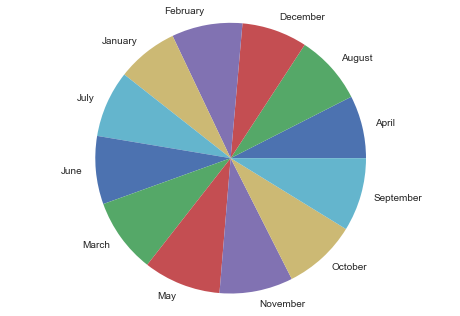

In [152]:
matplotlib.style.use('seaborn')

trueHigher = stocks.loc[stocks['closedHigher'] == True]

num_higher = trueHigher.groupby('monthNames')['closedHigher'].sum()
plt = num_higher.plot(kind='pie')
plt.axis('equal')
plt.set_ylabel('')